In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

# --- Imports ---
from stage2_dataset import ColorizationDataset
from stage2_models import GeneratorUNet, Discriminator, weights_init_normal
from stage2_utils import plot_stage2_val, evaluate_metrics
from stage2_loss import PerceptualLoss # <--- NEW IMPORT

# --- Config ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DATASET_PATH = r".\dataset"
IMAGE_SIZE = 256
BATCH_SIZE = 16
NUM_WORKERS = 3
NUM_EPOCHS = 100
LEARNING_RATE = 2e-4
CHECKPOINT_DIR = './checkpoint_color'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True

def main():
    # 1. Data
    full_ds = ColorizationDataset(DATASET_PATH, IMAGE_SIZE)
    train_size = int(0.9 * len(full_ds))
    val_size = len(full_ds) - train_size
    train_ds, val_ds = random_split(full_ds, [train_size, val_size])
    
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    
    # 2. Models
    generator = GeneratorUNet().to(DEVICE)
    discriminator = Discriminator().to(DEVICE)
    generator.apply(weights_init_normal)
    discriminator.apply(weights_init_normal)
    
    # 3. Optimizers
    opt_G = torch.optim.Adam(generator.parameters(), lr=1e-6, betas=(0.5, 0.999))
    opt_D = torch.optim.Adam(discriminator.parameters(), lr=1e-5, betas=(0.5, 0.999))
    
    criterion_GAN = nn.BCEWithLogitsLoss()
    criterion_L1 = nn.L1Loss()
    criterion_VGG = PerceptualLoss(DEVICE)
    scaler = torch.amp.GradScaler('cuda')
    
    # 4. Resume Logic
    start_epoch = 0
    best_lpips = float('inf')

    if os.path.exists(f"{CHECKPOINT_DIR}/last.pth"):
        print("Found last.pth! Resuming training...")
        ckpt = torch.load(f"{CHECKPOINT_DIR}/last.pth", map_location=DEVICE, weights_only=False)
        generator.load_state_dict(ckpt['G'])
        discriminator.load_state_dict(ckpt['D'])
        opt_G.load_state_dict(ckpt['opt_G'])
        opt_D.load_state_dict(ckpt['opt_D'])
        scaler.load_state_dict(ckpt['scaler'])
        start_epoch = ckpt['epoch'] + 1
        best_lpips = ckpt.get('best_lpips', float('inf'))
        print(f"Resuming from Epoch {start_epoch+1}. Best LPIPS so far: {best_lpips:.4f}")

    print(f"Starting Colorization Training for {NUM_EPOCHS} epochs...")
    
    # 5. Training Loop
    for epoch in range(start_epoch, NUM_EPOCHS):
        generator.train()
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
        
        for L, ab_real in loop:
            L = L.to(DEVICE)
            ab_real = ab_real.to(DEVICE)
            
            # --- Generator ---
            opt_G.zero_grad()
            with torch.amp.autocast('cuda'):
                ab_fake = generator(L)
                
                pred_fake = discriminator(ab_fake, L)
                loss_gan = criterion_GAN(pred_fake, torch.ones_like(pred_fake))
                loss_pixel = criterion_L1(ab_fake, ab_real)
                loss_vgg = criterion_VGG(L, ab_fake, L, ab_real)
                
                loss_G = loss_gan + (10.0 * loss_pixel) + (5.0 * loss_vgg)
                
            scaler.scale(loss_G).backward()
            scaler.step(opt_G)
            
            # --- Discriminator ---
            opt_D.zero_grad()
            with torch.amp.autocast('cuda'):
                pred_real = discriminator(ab_real, L)
                loss_real = criterion_GAN(pred_real, torch.ones_like(pred_real))
                pred_fake = discriminator(ab_fake.detach(), L)
                loss_fake = criterion_GAN(pred_fake, torch.zeros_like(pred_fake))
                loss_D = 0.5 * (loss_real + loss_fake)
                
            scaler.scale(loss_D).backward()
            scaler.step(opt_D)
            scaler.update()
            
            loop.set_postfix(G=loss_G.item(), D=loss_D.item())
        
        # --- Validation & Saving (EVERY EPOCH) ---
        # Calculate metrics
        val_psnr, val_ssim, val_lpips = evaluate_metrics(generator, val_loader, DEVICE, criterion_VGG)
        print(f"Epoch {epoch+1}: PSNR: {val_psnr:.2f} | SSIM: {val_ssim:.4f} | LPIPS: {val_lpips:.4f}")

        checkpoint = {
            'epoch': epoch,
            'G': generator.state_dict(),
            'D': discriminator.state_dict(),
            'opt_G': opt_G.state_dict(),
            'opt_D': opt_D.state_dict(),
            'scaler': scaler.state_dict(),
            'best_lpips': best_lpips
        }

        # 1. Save 'last.pth' (Overwrite)
        torch.save(checkpoint, f"{CHECKPOINT_DIR}/last.pth")
        
        # 2. Save 'best.pth' (If LPIPS improves)
        if val_lpips < best_lpips:
            print(f"New Best LPIPS! ({val_lpips:.4f}). Saving best.pth...")
            best_lpips = val_lpips
            checkpoint['best_lpips'] = best_lpips
            torch.save(checkpoint, f"{CHECKPOINT_DIR}/best.pth")

        # 3. Save Permanent History (EVERY EPOCH)
        # Logic: removed the "% 5" check so it saves every single time.
        torch.save(checkpoint, f"{CHECKPOINT_DIR}/epoch_{epoch+1}.pth")
        
        # Plot samples
        generator.eval()
        with torch.no_grad():
            L_val, ab_val = next(iter(val_loader))
            ab_pred = generator(L_val.to(DEVICE))
            plot_stage2_val(L_val, ab_pred, ab_val, epoch, CHECKPOINT_DIR)
    

In [2]:
if __name__ == "__main__":
    main()

Stage 2: Loading 15999 Optical images into RAM...


  0%|          | 0/15999 [00:00<?, ?it/s]

100%|██████████| 15999/15999 [01:59<00:00, 133.88it/s]


Found last.pth! Resuming training...
Resuming from Epoch 76. Best LPIPS so far: 0.6216
Starting Colorization Training for 100 epochs...


Epoch 76/100: 100%|██████████| 900/900 [06:01<00:00,  2.49it/s, D=0.567, G=4.95] 


Epoch 76: PSNR: 29.07 | SSIM: 0.8986 | LPIPS: 0.6232


Epoch 77/100: 100%|██████████| 900/900 [06:22<00:00,  2.35it/s, D=0.575, G=4.44] 
d:\My Disk\coding\jorkinmapython\stage2_utils.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  rgb = lab2rgb(img.astype(np.float64))


Epoch 77: PSNR: 28.96 | SSIM: 0.8974 | LPIPS: 0.6229


Epoch 78/100: 100%|██████████| 900/900 [06:18<00:00,  2.38it/s, D=0.569, G=4.84] 


Epoch 78: PSNR: 28.74 | SSIM: 0.8929 | LPIPS: 0.6311


Epoch 79/100:  34%|███▍      | 308/900 [03:02<05:50,  1.69it/s, D=0.6, G=4.18]   


KeyboardInterrupt: 

Loading Stage 2 Model from ./checkpoint_color/best.pth...
Image Analysis Results:
PSNR: 24.15 dB
SSIM: 0.7286


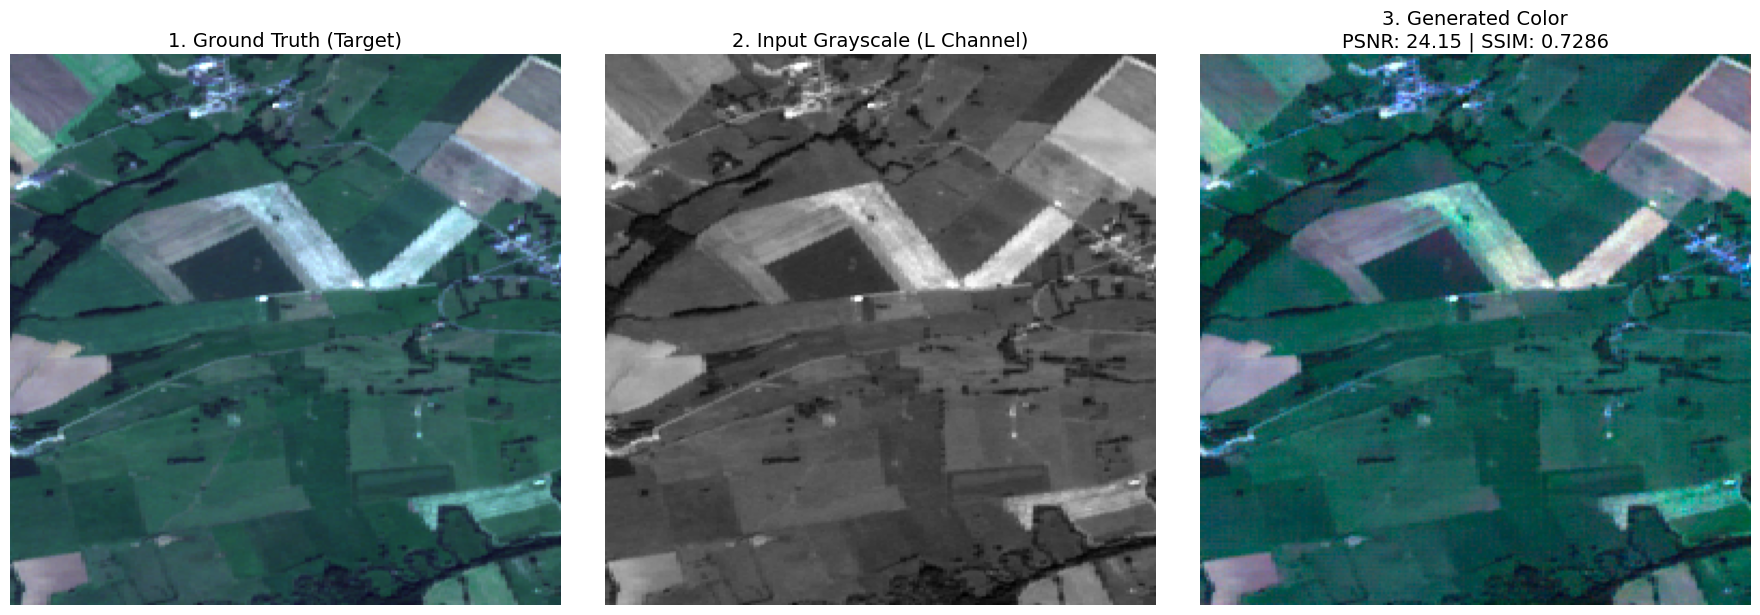

Saved comparison to stage2_validation_metrics.png


<Figure size 640x480 with 0 Axes>

In [5]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T
from skimage import color
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# --- IMPORTS ---
from stage2_models import GeneratorUNet

# --- CONFIGURATION ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMAGE_SIZE = 256

# 1. PATH TO MODEL
STAGE2_CHECKPOINT = "./checkpoint_color/best.pth"

# 2. PATH TO CUSTOM IMAGE (Ground Truth Optical Image)
TEST_IMAGE_PATH = r"./dataset/optical/ROIs1868_summer_s2_59_p34.png" 

def load_model():
    print(f"Loading Stage 2 Model from {STAGE2_CHECKPOINT}...")
    model = GeneratorUNet().to(DEVICE)
    
    if not os.path.exists(STAGE2_CHECKPOINT):
        raise FileNotFoundError(f"Checkpoint not found at {STAGE2_CHECKPOINT}")
        
    ckpt = torch.load(STAGE2_CHECKPOINT, map_location=DEVICE, weights_only=False)
    
    # Handle different save formats (Dict vs Direct)
    if isinstance(ckpt, dict) and 'G' in ckpt:
        model.load_state_dict(ckpt['G'])
    else:
        model.load_state_dict(ckpt)
        
    model.eval()
    return model

def calculate_metrics(gt_img, pred_img):
    """
    Calculates PSNR and SSIM between Ground Truth and Predicted RGB images.
    Images should be numpy arrays (H, W, 3) or (H, W) in range [0, 255] or [0, 1].
    """
    # Ensure images are the same type and range for fair comparison
    if gt_img.dtype != pred_img.dtype:
        pred_img = pred_img.astype(gt_img.dtype)

    # Calculate PSNR
    # data_range=255 because we are using uint8 images [0-255]
    psnr_val = psnr(gt_img, pred_img, data_range=255)
    
    # Calculate SSIM
    # channel_axis=-1 tells ssim that the last dimension (3) is color channels
    ssim_val = ssim(gt_img, pred_img, data_range=255, channel_axis=-1)
    
    return psnr_val, ssim_val

def colorize_single_image(image_path, model, saturation=1.0):
    # 1. Load Image (Ground Truth RGB)
    original_rgb = Image.open(image_path).convert("RGB").resize((IMAGE_SIZE, IMAGE_SIZE))
    original_np = np.array(original_rgb)
    
    # 2. Convert to Lab
    # We use the L channel as input to test the model
    lab_image = color.rgb2lab(original_np).astype(np.float32)
    L_channel = lab_image[:, :, 0]  # Range [0, 100]
    
    # 3. Prepare Input Tensor
    # Normalize L to [-1, 1] for the GAN
    L_norm = (L_channel / 50.0) - 1.0
    L_tensor = torch.from_numpy(L_norm).unsqueeze(0).unsqueeze(0).to(DEVICE) # (B, C, H, W)
    
    # 4. Inference
    with torch.no_grad():
        fake_ab_tensor = model(L_tensor)
        
    # 5. Post-Processing
    # Un-normalize L (Back to 0-100)
    L_final = (L_tensor.squeeze().cpu().numpy() + 1.0) * 50.0
    
    # Un-normalize ab (Back to -128 to 128) + Saturation Boost
    ab_final = fake_ab_tensor.squeeze().cpu().numpy().transpose(1, 2, 0) * 128.0 * saturation
    
    # 6. Combine into Lab Image
    result_lab = np.zeros((IMAGE_SIZE, IMAGE_SIZE, 3))
    result_lab[:, :, 0] = L_final
    result_lab[:, :, 1:] = ab_final
    
    # 7. Convert back to RGB
    # Clip values to prevent mathematical errors in conversion
    result_lab[:, :, 0] = np.clip(result_lab[:, :, 0], 0, 100)
    result_lab[:, :, 1:] = np.clip(result_lab[:, :, 1:], -128, 128)
    
    try:
        result_rgb = color.lab2rgb(result_lab)
        # Convert to uint8 (0-255) to match original_np
        result_rgb = (result_rgb * 255).astype(np.uint8)
    except ValueError:
        print("Warning: Color math error, employing safe clip.")
        safe_lab = np.clip(result_lab, -100, 100)
        result_rgb = color.lab2rgb(safe_lab)
        result_rgb = (result_rgb * 255).astype(np.uint8)
        
    return original_np, L_channel, result_rgb

def main():
    # Load
    model = load_model()
    
    # Process
    # Try saturation=1.5 or 2.0 if colors are too dull
    gt_img, input_l, pred_img = colorize_single_image(TEST_IMAGE_PATH, model, saturation=1.5)
    
    # --- CALCULATE METRICS ---
    psnr_score, ssim_score = calculate_metrics(gt_img, pred_img)
    print(f"Image Analysis Results:")
    print(f"PSNR: {psnr_score:.2f} dB")
    print(f"SSIM: {ssim_score:.4f}")

    # Plot
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. Ground Truth
    ax[0].imshow(gt_img)
    ax[0].set_title("1. Ground Truth (Target)", fontsize=14)
    ax[0].axis("off")
    
    # 2. Input (What the model saw)
    ax[1].imshow(input_l, cmap='gray')
    ax[1].set_title("2. Input Grayscale (L Channel)", fontsize=14)
    ax[1].axis("off")
    
    # 3. Output (What the model predicted)
    ax[2].imshow(pred_img)
    # Display metrics in title
    ax[2].set_title(f"3. Generated Color\nPSNR: {psnr_score:.2f} | SSIM: {ssim_score:.4f}", fontsize=14)
    ax[2].axis("off")
    
    plt.tight_layout()
    plt.show()
    
    # Optional: Save Comparison
    plt.savefig("stage2_validation_metrics.png")
    print("Saved comparison to stage2_validation_metrics.png")

if __name__ == "__main__":
    main()